# <font size='6px'>
  <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🔗 Build Link-Prediction Model to Predict Edge-Level Anomaly 🌐</p>
</font>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import negative_sampling, train_test_split_edges

from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, roc_auc_score, confusion_matrix

c:\Pytorch\Torchify\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <font size='6px'>
  <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>📥 Load Data 📚</p>
</font>

In [2]:
# LOAD DATA

bank_accounts = pd.read_parquet(r"C:\Pytorch\Fraud Detection\data\bank_accounts.parquet")
cards = pd.read_parquet(r"C:\Pytorch\Fraud Detection\data\credit_cards.parquet")
devices = pd.read_parquet(r"C:\Pytorch\Fraud Detection\data\devices.parquet")
transactions = pd.read_parquet(r"C:\Pytorch\Fraud Detection\data\transactions.parquet")

In [3]:
print('Bank Accounts : ', bank_accounts.shape)
display(bank_accounts.head(5))
print('\nCredit Cards : ', cards.shape)
display(cards.head(5))
print('\nDevices : ', devices.shape)
display(devices.head(5))
print('\nTransactions : ', transactions.shape)
display(transactions.head(5))

Bank Accounts :  (350841, 2)


,user_id,bank_account
0,C419128,0
1,C19901940,0
2,C21407120,0
3,C54966514,0
4,C80507942,0000039209



Credit Cards :  (38708, 2)


,user_id,credit_card
0,C63177098,30024x08-2020
1,C18468478,30024x08-2021
2,C22163518,30024x12-2020
3,C5845542,30134x02-2021
4,C31447074,30134x10-2017



Devices :  (1430311, 2)


,user_id,device
0,C10146534,+++3s/8YvFLP/ePRr1RQw27UpSq8iJAdybTVjPiHUc8=
1,C123913948,+++GW0vx4xLjxTNHKWO+kWDS+w45sJZz//ZUlST6TCg=
2,C147271198,+++b/gSDahdOss9vZHx/0qorN1zrvnT0DJ6vttl/YBE=
3,C16126238,+++hbM5PFzSOZglwP8ORRbmr40UrvzEgCMq6ZtuJjMu=
4,C102164030,+++ivFTF+M/DxnA21MRSxuqZO/KUheIu0RXva/O41sq=



Transactions :  (620947, 4)


,transid,org_user_id,dest_user_id,amount
0,1953278092,C47388162,C20822974,99094
1,1953295120,C26855196,C16416890,52714
2,1953306402,C121296714,C28477978,43888
3,1953314712,C131221930,C72837912,45771
4,1953381964,C183398314,C28423332,96840


# <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🔄 Preprocessing 🧰</p>


In [4]:
# DROP DUPLICATE SAMPLE

def drop_duplicate(data, subset = None):

    dupe = data.duplicated(subset = subset).sum()
    print(f'Deleted {dupe} Duplicated Data')

    return data.drop_duplicates()


bank_accounts = drop_duplicate(bank_accounts)
cards  = drop_duplicate(cards)
devices = drop_duplicate(devices)
transactions = drop_duplicate(transactions)

Deleted 269 Duplicated Data
Deleted 693 Duplicated Data
Deleted 0 Duplicated Data
Deleted 0 Duplicated Data


## <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'> 🧩 Label Encoding 🔢</p>

In [ ]:
# TRANSFORM USER_ID INTO LABEL

# EDGES TRANSACTION
edges = transactions[['org_user_id', 'dest_user_id', 'amount']].copy()
edges.rename(columns={'org_user_id': 'src', 'dest_user_id': 'dst'}, inplace=True)

# LIST OF UNIQUE USERS (LIKE LABEL ENCODING)
users = pd.Series(pd.concat([edges['src'], edges['dst']])).unique()
user2id = {u: i for i, u in enumerate(users)}

# INSERT ENCODED VALUE AS NEW FEATURES
edges['src_id'] = edges['src'].map(user2id)
edges['dst_id'] = edges['dst'].map(user2id)

edges

,src,dst,amount,src_id,dst_id
0,C47388162,C20822974,99094,0,416105
1,C26855196,C16416890,52714,1,416106
2,C121296714,C28477978,43888,2,416107
3,C131221930,C72837912,45771,3,281886
4,C183398314,C28423332,96840,4,416108
...,...,...,...,...,...
620942,C14222102,C70940136,54658,416103,433923
620943,C2978154,C60766142,26739,416104,420326
620944,C221974772,C15541938,42036,64022,421090
620945,C152533590,C80986700,66580,106593,340093


## <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'> 🧩 Feature Engineering 🧪</p>


In [ ]:
# SET FEATURE ENGINEERING ON TRANSACTION DATASET

# CREATE DEGREE
out_degree = edges.groupby('src').size().rename('out_degree')  # ---> THE NUMBER OF TRANSACTIONS MADE BY THE ACCOUNT
in_degree = edges.groupby('dst').size().rename('in_degree')    # ---> NUMBER OF INCOMING TRANSACTIONS FROM THAT ACCOUNT

# AGGREGATION FEATURES
out_amount_sum = edges.groupby('src')['amount'].sum().rename('out_sum')
in_amount_sum = edges.groupby('dst')['amount'].sum().rename('in_sum')
out_amount_mean = edges.groupby('src')['amount'].mean().rename('out_mean')
in_amount_mean = edges.groupby('dst')['amount'].mean().rename('in_mean')

# CREATE NODE FEATURES BASED ON ENGINEERED FEATURE
node_features = pd.concat([out_degree, in_degree, out_amount_sum, in_amount_sum, out_amount_mean, in_amount_mean], axis=1).fillna(0)

# CREATE RATIO FEATURES
node_features['degree_ratio'] = (node_features['out_degree'] + 1) / (node_features['in_degree'] + 1)
node_features['amount_ratio'] = (node_features['out_sum'] + 1) / (node_features['in_sum'] + 1)

# LOG TRANSFORM NORMALIZATION FOR EACH NODE FEATURES
#for col in node_features.columns:
#    node_features[col] = np.log1p(node_features[col])

node_features

,out_degree,in_degree,out_sum,in_sum,out_mean,in_mean,degree_ratio,amount_ratio
C100000188,1.0,0.0,44574.0,0.0,44574.0,0.000000,2.000000,44575.000000
C10000108,1.0,0.0,20156.0,0.0,20156.0,0.000000,2.000000,20157.000000
C100001610,1.0,0.0,54207.0,0.0,54207.0,0.000000,2.000000,54208.000000
C100001712,5.0,0.0,139464.0,0.0,27892.8,0.000000,6.000000,139465.000000
C100001882,1.0,0.0,48024.0,0.0,48024.0,0.000000,2.000000,48025.000000
...,...,...,...,...,...,...,...,...
C99976312,0.0,1.0,0.0,46743.0,0.0,46743.000000,0.500000,0.000021
C9998782,0.0,1.0,0.0,73663.0,0.0,73663.000000,0.500000,0.000014
C99990,0.0,1.0,0.0,18642.0,0.0,18642.000000,0.500000,0.000054
C99991228,0.0,7.0,0.0,252220.0,0.0,36031.428571,0.125000,0.000004


In [ ]:
# FEATURE ENGINEERING - MORE AGGREGATION FEATURES

def aggregation_feature(data, user_col, item_col, rename):

    # COUNT UNIQUE ITEM EACH USER HAVE
    n_unique_item_per_user = data.groupby(by = user_col)[item_col].nunique().rename(rename[0])

    # COUNT HOW MANY USER HAVE A SAME ITEM
    item_user_count =  data.groupby(by = item_col)[user_col].nunique().rename('n_user_per_item')

    # HOW MANY DEVICES OWNED BY THIS USER R ALSO USED BY OTHER USERS
    # 1 MEANS THERE'S SHARED ITEM (device, bank, cc) USED BY OTHER user_id. 0 MEANS NO SHARED ITEM TO OTHER user_id

    # CHECK IF THAT ITEM IS USED BY MORE THAN 1 USER (SHARED ITEM)
    df_item = data.merge(item_user_count, on = item_col, how='left')
    df_item['is_shared_item'] = (df_item['n_user_per_item'] > 1).astype(int)

    # COUNT SHARED ITEM PER USER
    n_shared_item = df_item.groupby(user_col)['is_shared_item'].sum().rename(rename[1])

    # --- COUNT N-USER CONNECTED --- (ALL USER USE A SAME ITEM)
    item_to_users = data.groupby(item_col)[user_col].apply(lambda x: set(x)).rename("user_sets_per_item")

    df_count = data.merge(item_to_users, on=item_col)

    def count_other_users(s):
        connected = set()
        for users in s:
            if len(users) > 1:
                connected |= users
        return max(len(connected) - 1, 0)  # exclude diri sendiri
    
    n_user_connected = (df_count.groupby(user_col)["user_sets_per_item"].apply(count_other_users).rename("n_user_connected"))

    # --- DEGREE CENTRALITY (NORMALIZED) ---
    degree_centrality = (n_user_connected / n_user_connected.max()).rename("degree_centrality")

    # --- MERGE ALL FEATURES ENGINEERED ---
    result = (n_unique_item_per_user.to_frame().merge(n_shared_item.to_frame(), on=user_col, how='left') \
                                               .merge(n_user_connected.to_frame(), on=user_col, how='left') \
                                               .merge(degree_centrality.to_frame(), on=user_col, how='left').reset_index())

    # --- ADD SHARED RATIO ---
    result["shared_ratio"] = (result[rename[1]] / result[rename[0]].replace(0, 1))

    return result


devices_agg = aggregation_feature(data = devices, user_col = 'user_id', item_col = 'device', rename = ['n_unique_devices_per_user', 'n_shared_devices_per_user'])
bank_accounts_agg = aggregation_feature(data = bank_accounts, user_col = 'user_id', item_col = 'bank_account', rename = ['n_unique_bank_per_user', 'n_shared_bank_per_user'])
cards_agg = aggregation_feature(data = cards, user_col = 'user_id', item_col = 'credit_card', rename = ['n_unique_credit_card_per_user', 'n_shared_credit_card_per_user'])

devices_agg

,user_id,n_unique_devices_per_user,n_shared_devices_per_user,n_user_connected,degree_centrality,shared_ratio
0,C100000188,2,0,0,0.000000,0.000000
1,C10000108,3,1,1,0.014286,0.333333
2,C10000114,14,5,3,0.042857,0.357143
3,C100001610,2,0,0,0.000000,0.000000
4,C100001712,6,0,0,0.000000,0.000000
...,...,...,...,...,...,...
481514,C99995312,2,0,0,0.000000,0.000000
481515,C99997576,1,0,0,0.000000,0.000000
481516,C99998872,2,0,0,0.000000,0.000000
481517,C99999032,4,0,0,0.000000,0.000000


In [ ]:
# ADD THOSE AGGREGATED FEATURES (device, credit_card, bank_account) INTO node_features

# MERGE ITEM FEATURE 
merged_item = pd.merge(devices_agg, cards_agg, on = 'user_id', how = 'outer').merge(bank_accounts_agg, on = 'user_id', how = 'outer').drop_duplicates().fillna(0)

# MERGE ITEM FEATURE WITH NODE FEATURE
node_features = pd.merge(merged_item, node_features, left_on = 'user_id', how = 'right', right_index = True).fillna(0)
node_features = node_features.set_index('user_id')

# LOG TRANSFORM NORMALIZATION FOR EACH NODE FEATURES
for col in node_features.columns:
    node_features[col] = np.log1p(node_features[col])


node_features

,n_unique_devices_per_user,n_shared_devices_per_user,n_user_connected_x,degree_centrality_x,shared_ratio_x,n_unique_credit_card_per_user,n_shared_credit_card_per_user,n_user_connected_y,degree_centrality_y,shared_ratio_y,...,degree_centrality,shared_ratio,out_degree,in_degree,out_sum,in_sum,out_mean,in_mean,degree_ratio,amount_ratio
user_id,,,,,,,,,,,,,,,,,,,,,
C100000188,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.693147,0.000000,10.704928,0.000000,10.704928,0.000000,1.098612,10.704951
C10000108,1.386294,0.693147,0.693147,0.014185,0.287682,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010471,0.693147,0.693147,0.000000,9.911307,0.000000,9.911307,0.000000,1.098612,9.911357
C100001610,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.693147,0.000000,10.900584,0.000000,10.900584,0.000000,1.098612,10.900602
C100001712,1.945910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.791759,0.000000,11.845569,0.000000,10.236160,0.000000,1.945910,11.845576
C100001882,1.791759,1.098612,1.098612,0.028171,0.336472,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.693147,0.000000,10.779477,0.000000,10.779477,0.000000,1.098612,10.779498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C99976312,1.098612,0.693147,0.693147,0.014185,0.405465,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.693147,0.000000,10.752441,0.000000,10.752441,0.405465,0.000021
C9998782,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.693147,0.000000,11.207269,0.000000,11.207269,0.405465,0.000014
C99990,1.098612,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147,2.397895,0.016695,0.693147,...,0.000000,0.000000,0.000000,0.693147,0.000000,9.833226,0.000000,9.833226,0.405465,0.000054


## <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'> 🕸️ Build Graph Data 🗺️</p>

In [ ]:
# BUILD GRAPH OBJECT

# CONVERT EDGE TO TENSORS
edge_index = torch.tensor([edges['src_id'].values, edges['dst_id'].values], dtype = torch.long)

# CONVERT NODE TO TENSORS
node = torch.tensor(node_features.values, dtype = torch.float)

# EDGE ATTRIBUTE
edge_attribute = torch.tensor(data = edges['amount'], dtype = torch.float).unsqueeze(1)

# CREATE GRAPH DATASET
graph_data = Data(x = node, edge_index = edge_index, edge_attr = edge_attribute)

graph_data

C:\Users\aliff\AppData\Local\Temp\ipykernel_13084\2389439144.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  edge_index = torch.tensor([edges['src_id'].values, edges['dst_id'].values], dtype = torch.long)


Data(x=[486277, 23], edge_index=[2, 620947], edge_attr=[620947, 1])

## <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'> 🧵 Split Data : Inductive Split 🧾</p>

In [ ]:
# SPLIT DATA

def inductive_split(graph, num_train, num_val, use_test = True, mode = 'strict'):

    # SHUFFLE NODES
    num_nodes = graph.num_nodes
    shuffle_all_nodes = np.random.permutation(num_nodes)

    # SPLIT PROPORTION
    train_split = int(num_train * num_nodes)
    val_split   = int(num_val * num_nodes)

    # SPLIT NODES
    train_nodes = torch.tensor(shuffle_all_nodes[:train_split])
    val_nodes   = torch.tensor(shuffle_all_nodes[train_split : train_split + val_split])
    test_nodes = torch.tensor(shuffle_all_nodes[train_split + val_split:])  if use_test else None

    # DETERMINE SOURCE AND TEST NODE
    edge_index = graph.edge_index
    src, dst   = edge_index[0], edge_index[1]

    # FILTER EDGES
    def filter_edges(subset_node):
        return torch.isin(src, subset_node) & torch.isin(dst, subset_node)   # ONLY GET EDGES WHERE THE 2 NODES ARE IN THE SAME SPLIT
    
    # APPLY FILTER
    train_mask = filter_edges(train_nodes)
    val_mask   = filter_edges(val_nodes)
    test_mask  = filter_edges(test_nodes)

    if mode == 'soft':
        # EDGE THAT IS DISCARDED IN TRAIN/VAL DATA WILL BE INCLUDED IN TESTING DATA
        cross_mask = ~(train_mask | val_mask | test_mask)
        test_mask = test_mask | cross_mask

    # SPLIT EDGES
    train_edges = edge_index[:, train_mask]
    val_edges   = edge_index[:, val_mask]
    test_edges  = edge_index[:, test_mask]

    actual_train_ratio = train_edges.size(1) / edge_index.size(1)
    if actual_train_ratio < 0.8:
        print(f"⚠️ Train edge ratio drops to {actual_train_ratio:.2f}. ")

    # BUILD GRAPH
    train_graph = Data(x = graph.x, edge_index = train_edges, edge_attr = graph.edge_attr[train_mask])

    print(f'Train Edges : {train_edges.size(1)}')
    print(f'Val Edges   : {val_edges.size(1)}')
    print(f'Test Edges  : {test_edges.size(1)}')
    
    return train_graph, train_edges, val_edges, test_edges


train_graph, train_edges, val_edges, test_edges = inductive_split(graph = graph_data, num_train = 0.8, num_val = 0.1, use_test = True, mode = 'soft')

train_graph

⚠️ Train edge ratio drops to 0.64. 
Train Edges : 396790
Val Edges   : 6298
Test Edges  : 217859


Data(x=[486277, 23], edge_index=[2, 396790], edge_attr=[396790, 1])

## <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🔄 Data Loader : Neighbor Loader 🧭</p>

In [ ]:
# NEIGHBOR LOADER (DATA LOADER)

data_loader = LinkNeighborLoader(data = train_graph, 
                                 num_neighbors = [10, 5], 
                                 edge_label_index = train_edges, 
                                 batch_size = 1024,
                                 neg_sampling_ratio = 1.0, 
                                 shuffle = True)

data_loader

LinkNeighborLoader()

## <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🧠 Build Architecture : GraphSAGE 🕸️</p>

In [ ]:
# BUILD GNN ARCHITECTURE

class GraphSAGE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, dropout):
        super().__init__()
        
        self.sage1 = SAGEConv(in_channels = input_channels, out_channels = hidden_channels, aggr = 'mean')
        self.norm = torch.nn.LayerNorm(hidden_channels)

        self.sage2 = SAGEConv(in_channels = hidden_channels, out_channels = output_channels, aggr = 'mean') 
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()

    # FORWARD PROPAGATION
    def forward(self, x, edge_index):

        # FIRST HIDDEN LAYER
        hidden1 = self.norm(self.sage1(x, edge_index))
        relu = self.relu(hidden1)
        dropout = self.dropout(relu)
        
        # SECOND HIDDEN LAYERS
        hidden2 = self.sage2(dropout, edge_index)

        return hidden2
    
# CLASSIFICATION HEAD
class LinkPredictor(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels = 64):
        super().__init__()

        self.linear1 = torch.nn.Linear(in_features = input_channels * 2, out_features = hidden_channels)
        self.output = torch.nn.Linear(in_features = hidden_channels, out_features = 1)

        self.relu = torch.nn.ReLU()

    def forward(self, x_src, x_dst):

        concat = torch.cat([x_src, x_dst], dim = -1)  # --> CONCAT SRC AND DST EMBEDDING
        layer = self.relu(self.linear1(concat))

        # OUTPUT LAYER
        output = torch.sigmoid(self.output(layer))  

        return output

In [ ]:
# INITIALIZATION GNN ARCHITECTURE

# ENCODER LAYER
encoder = GraphSAGE(input_channels  = graph_data.num_features,
                    hidden_channels = 128,
                    output_channels = 64,
                    dropout = 0.4).to('cuda')

# CLASSIFICATION HEAD
clf_head = LinkPredictor(input_channels = 64, hidden_channels = 64).to('cuda')

encoder, clf_head

(GraphSAGE(
   (sage1): SAGEConv(23, 128, aggr=mean)
   (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   (sage2): SAGEConv(128, 64, aggr=mean)
   (dropout): Dropout(p=0.4, inplace=False)
   (relu): ReLU()
 ),
 LinkPredictor(
   (linear1): Linear(in_features=128, out_features=64, bias=True)
   (output): Linear(in_features=64, out_features=1, bias=True)
   (relu): ReLU()
 ))

## <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🤖 Training Pipeline 🎯</p>

In [ ]:
# EVALUATE MODEL

def evaluate(encoder, clf_head, graph, edge_index, device='cuda', plot_confusion_matrix = False):

    encoder.eval()
    clf_head.eval()
    
    with torch.no_grad():
        graph = graph.to(device)
        z = encoder(graph.x, graph.edge_index)

        # DEFINE SRC AND DST
        src, dst = edge_index[0], edge_index[1]

        # PREDICT POSITIVE EDGES (CLASSIFICATION LAYER)
        pos_pred = clf_head(z[src], z[dst]).view(-1).cpu()
        pos_label = torch.ones_like(pos_pred)

        # CREATE RANDOM NEGATIVE SAMPLING
        from torch_geometric.utils import negative_sampling
        neg_edges = negative_sampling(edge_index=edge_index, num_nodes=graph.num_nodes, num_neg_samples=edge_index.size(1))
        neg_src, neg_dst = neg_edges[0], neg_edges[1]

        # PREDICT NEGATIVE SAMPLING
        neg_pred = clf_head(z[neg_src], z[neg_dst]).view(-1).cpu()
        neg_label = torch.zeros_like(neg_pred)

        # CONCAT POSITIVE SAMPLING WITH NEGATIVE SAMPLING
        preds = torch.cat([pos_pred, neg_pred])
        labels = torch.cat([pos_label, neg_label])

        # METRIC EVALUATION
        roc_auc = roc_auc_score(labels, preds)
        ap = average_precision_score(labels, preds)

        # PLOT CF?
        if plot_confusion_matrix:
            y_pred = (preds > 0.5).int()
            conf_matrix = confusion_matrix(labels, y_pred)
            sns.heatmap(conf_matrix, annot = True, fmt = '2f', cmap = 'coolwarm')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

    return roc_auc, ap

In [ ]:
# TRAIN GNN

# SET OPT
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(clf_head.parameters()), lr = 1e-3)

train_loss_per_epoch, val_auc_per_epoch, test_auc_per_epoch = [], [], []

print(f'START TRAINING!')

# START TRAINING
EPOCH = 6
for epoch in range(1, EPOCH + 1):

    encoder.train()
    clf_head.train()

    train_loss = 0  # --> CHECK TRAIN LOSS PER EPOCH

    # FOR EACH BATCH
    for batch in tqdm(data_loader):
        batch = batch.to('cuda')

        # ENCODER LAYER
        node_embedded = encoder(batch.x, batch.edge_index)

        # GET NODES PAIR (SRC, DST)
        src, dst = batch.edge_label_index  # --> GET EDGE EMBEDDING FROM POSITIVE SRC AND DST

        # GET LABEL 1 = POSITIVE, 0 = NEGATIVE
        label = batch.edge_label.float().view(-1, 1)

        # CLASSIFICATION LAYER
        pred = clf_head(node_embedded[src], node_embedded[dst])


        # BINARY CROSS ENTROPY LOSS
        loss = torch.nn.functional.binary_cross_entropy(pred, label)
        train_loss += loss.item()

        # BACKPROPAGATION
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # ACCUMMULATE LOSS FUNCTION PER EPOCHS
    avg_loss = train_loss / len(data_loader)   # --> TAKE AVERAGE LOSS PER BATCH
    train_loss_per_epoch.append(train_loss)

    train_auc, train_ap = evaluate(encoder, clf_head, graph_data, train_edges)
    val_auc, val_ap = evaluate(encoder, clf_head, graph_data, val_edges)
    test_auc, test_ap = evaluate(encoder, clf_head, graph_data, test_edges)

    val_auc_per_epoch.append(val_auc)
    test_auc_per_epoch.append(test_auc)

    print(f"Epoch {epoch}/{EPOCH} | Train Loss: {avg_loss:.4f} | "
          f"Train ROC-AUC: {train_auc:.4f} | Train AP: {train_ap:.4f} | "
          f"Val ROC-AUC: {val_auc:.4f} | Val AP: {val_ap:.4f} | "
          f"Test ROC-AUC: {test_auc:.4f} | Test AP: {test_ap:.4f}")

START TRAINING!


100%|██████████| 388/388 [00:12<00:00, 30.30it/s]


Epoch 1/6 | Train Loss: 0.1701 | Train ROC-AUC: 0.9579 | Train AP: 0.9319 | Val ROC-AUC: 0.9555 | Val AP: 0.9240 | Test ROC-AUC: 0.9579 | Test AP: 0.9313


100%|██████████| 388/388 [00:11<00:00, 33.74it/s]


Epoch 2/6 | Train Loss: 0.1277 | Train ROC-AUC: 0.9642 | Train AP: 0.9408 | Val ROC-AUC: 0.9638 | Val AP: 0.9375 | Test ROC-AUC: 0.9634 | Test AP: 0.9379


100%|██████████| 388/388 [00:10<00:00, 36.33it/s]


Epoch 3/6 | Train Loss: 0.1244 | Train ROC-AUC: 0.9723 | Train AP: 0.9588 | Val ROC-AUC: 0.9716 | Val AP: 0.9560 | Test ROC-AUC: 0.9720 | Test AP: 0.9581


100%|██████████| 388/388 [00:11<00:00, 33.33it/s]


Epoch 4/6 | Train Loss: 0.1153 | Train ROC-AUC: 0.9750 | Train AP: 0.9635 | Val ROC-AUC: 0.9727 | Val AP: 0.9560 | Test ROC-AUC: 0.9750 | Test AP: 0.9625


100%|██████████| 388/388 [00:17<00:00, 22.67it/s]


Epoch 5/6 | Train Loss: 0.1080 | Train ROC-AUC: 0.9758 | Train AP: 0.9667 | Val ROC-AUC: 0.9752 | Val AP: 0.9643 | Test ROC-AUC: 0.9758 | Test AP: 0.9665


100%|██████████| 388/388 [00:11<00:00, 33.12it/s]


Epoch 6/6 | Train Loss: 0.1057 | Train ROC-AUC: 0.9739 | Train AP: 0.9614 | Val ROC-AUC: 0.9753 | Val AP: 0.9604 | Test ROC-AUC: 0.9739 | Test AP: 0.9612


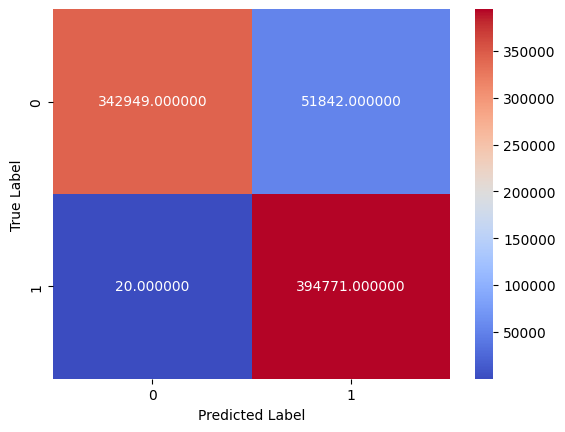

(0.9771631744352917, 0.9663815184357363)

In [ ]:
evaluate(encoder, clf_head, graph_data, train_edges, plot_confusion_matrix = True)

## <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🔮 Inference : Link Prediction 📈</p>

In [ ]:
# INFERENCE 1 EDGE - LINK PREDICTION

def predict_edge_anomaly(encoder, clf_head, graph, src_node, dst_node, threshold=0.5, device='cuda'):
    
    encoder.eval()
    clf_head.eval()

    with torch.no_grad():   # ---> DISABLE GRADIENT CALCULATION 
        graph = graph.to(device)

        # GET EMBEDDING FROM ENCODER
        z = encoder(graph.x, graph.edge_index)

        # GET SRC & DST EMBEDDING
        src_emb = z[src_node].unsqueeze(0)
        dst_emb = z[dst_node].unsqueeze(0)

        # PREDICT THE EDGE (CLASSIFICATION LAYER)
        prob = clf_head(src_emb, dst_emb).item()

        # DETERMINE THE LABEL 
        label = 1 if prob < threshold else 0   # contoh: makin kecil probabilitas → makin anomali

    return {'src_node': src_node, 
            'dst_node': dst_node,
            'probability': prob,
            'predicted_label': 'ANOMALI' if label == 1 else 'NORMAL'}

In [ ]:
# INFERENCE 1 NEW EDGE

# NEW EDGE
src_id, dst_id = 1897, 12460

result = predict_edge_anomaly(encoder  = encoder, clf_head = clf_head, graph = graph_data, 
                              src_node = src_id, dst_node = dst_id, threshold = 0.5)

print(result)

{'src_node': 1897, 'dst_node': 12460, 'probability': 2.3408019966808524e-09, 'predicted_label': 'ANOMALI'}


In [ ]:
# MULTI INFERENCE LINK PREDICTION ANOMALY DETECTION

def predict_links(encoder, clf_head, graph, node_pairs, threshold=0.5, device='cuda'):

    encoder.eval()
    clf_head.eval()

    with torch.no_grad():  # --> DISABLE GRADIENT CALCULATION
        graph = graph.to(device)

        # PREDICT EMBEDDING
        z = encoder(graph.x, graph.edge_index)

        # PREDICT LABEL (CLASSIFICATION HEAD)
        src, dst = node_pairs[:, 0].to(device), node_pairs[:, 1].to(device)
        probs = clf_head(z[src], z[dst]).view(-1).cpu().numpy()

    # FOR EACH SAMPLE
    results = []
    for i, (src, dst) in enumerate(node_pairs.tolist()):
        label = 'ANOMALI' if probs[i] < threshold else 'NORMAL'
        results.append({'src_node': src, 
                        'dst_node': dst, 
                        'probability': float(probs[i]), 
                        'predicted_label': label})

    return results


In [ ]:
# LINK PREDICTION

node_pairs = torch.tensor([[1, 23], [4, 56], [10, 200]])
results = predict_links(encoder, clf_head, graph_data, node_pairs)

for r in results:
    print(r)

{'src_node': 1, 'dst_node': 23, 'probability': 2.721577962994104e-10, 'predicted_label': 'ANOMALI'}
{'src_node': 4, 'dst_node': 56, 'probability': 3.0292790498265276e-10, 'predicted_label': 'ANOMALI'}
{'src_node': 10, 'dst_node': 200, 'probability': 1.158995455163847e-09, 'predicted_label': 'ANOMALI'}


In [ ]:
# LINK PREDICTION ON TEST DATA

results = predict_links(encoder, clf_head, graph_data, node_pairs = test_edges.T)

# DISPLAY 5 TEST SAMPLE
for r in results[:5]:
    print(r)

# CHECK IF THERE'S ANOMALY ON TEST DATA
count = 0
anomaly = []
for r in results:
    if r['predicted_label'] == 'ANOMALI':
        anomaly.append(r)
        count += 1
        
print(f"Found {count} Anomaly on test data")

{'src_node': 3, 'dst_node': 281886, 'probability': 0.980242908000946, 'predicted_label': 'NORMAL'}
{'src_node': 4, 'dst_node': 416108, 'probability': 0.9865714907646179, 'predicted_label': 'NORMAL'}
{'src_node': 5, 'dst_node': 416109, 'probability': 0.9830402731895447, 'predicted_label': 'NORMAL'}
{'src_node': 6, 'dst_node': 416110, 'probability': 0.9838931560516357, 'predicted_label': 'NORMAL'}
{'src_node': 7, 'dst_node': 416111, 'probability': 0.9846060276031494, 'predicted_label': 'NORMAL'}
Found 353 Anomaly on test data


## <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🚨 Analysis Edge Anomalies : Anomaly Detection 🧐</p>

In [ ]:
# DISPLAY TOP ANOMALIES

def inspect_edge_anomalies(encoder, clf_head, graph, edge_index, top_k=10, device='cuda'):

    encoder.eval()
    clf_head.eval()

    with torch.no_grad():  # --> DISABLE GRADIENT CALCULATION

        graph = graph.to(device)

        # GET EMBEDDINGS (ENCODER LAYER)
        z = encoder(graph.x, graph.edge_index)

        # GET SRC & DST EMBEDDING
        src, dst = edge_index[0], edge_index[1]

        # PREDICT LINK PROBABILITY
        probs = clf_head(z[src], z[dst]).view(-1).cpu()

    # SORT EDGE FROM THE LOWEST PROBABILITY (anomaly -> normal)
    sorted_idx = torch.argsort(probs)
    top_anomalies = sorted_idx[:top_k]
    top_normals = sorted_idx[-top_k:]

    # TOP-K MOST ANOMALY EDGE (LOWEST PROBABILITY)
    print(f"\n🧾 Top {top_k} Edge Anomali (Probabilitas paling rendah):")
    for i in top_anomalies:
        s, d, p = src[i].item(), dst[i].item(), probs[i].item()
        print(f"Edge ({s}, {d}) → Prob={p:.6f}")

    # TOP-K NORMAL EDGE (HIGHEST PROBABILITY)
    print(f"\n✅ Top {top_k} Edge Normal (Probabilitas paling tinggi):")
    for i in reversed(top_normals):
        s, d, p = src[i].item(), dst[i].item(), probs[i].item()
        print(f"Edge ({s}, {d}) → Prob={p:.6f}")

    return probs

In [ ]:
# GET EDGE WITH THE MOST ANOMALIES

probs = inspect_edge_anomalies(encoder = encoder, clf_head = clf_head, graph=graph_data, edge_index = test_edges, top_k = 10)


🧾 Top 10 Edge Anomali (Probabilitas paling rendah):
Edge (9649, 421574) → Prob=0.062554
Edge (233853, 427165) → Prob=0.119473
Edge (82059, 441242) → Prob=0.144758
Edge (130250, 450112) → Prob=0.216100
Edge (35675, 463564) → Prob=0.271781
Edge (111779, 446835) → Prob=0.275779
Edge (299533, 460454) → Prob=0.317730
Edge (91328, 443002) → Prob=0.324199
Edge (260445, 468541) → Prob=0.345590
Edge (75087, 439789) → Prob=0.373977

✅ Top 10 Edge Normal (Probabilitas paling tinggi):
Edge (117764, 151335) → Prob=0.998861
Edge (155187, 414736) → Prob=0.998589
Edge (147659, 336248) → Prob=0.998575
Edge (80664, 153368) → Prob=0.998575
Edge (405916, 172618) → Prob=0.998565
Edge (331693, 386447) → Prob=0.998482
Edge (295132, 93722) → Prob=0.998480
Edge (71205, 320471) → Prob=0.998455
Edge (18042, 81794) → Prob=0.998447
Edge (18042, 81794) → Prob=0.998447


## <p style='font-family: https://fonts.google.com/share?selection.family=Signika+Negative:wght@300..700; background-color:#C6F0FF; font-weight:bold; color:#10C0FF; border:4px solid #10C0FF; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>⭐ Link Recommendation 🛒</p>

Recommend new connections that are likely to connect in the future based on the similarity of a node

In [ ]:
# RECOMMENDATION FOR NEW CONNECTION EDGE FOR SPECIFIC USER

def recommend_links(encoder, clf_head, graph, node_id, top_k=5, device='cpu'):

    encoder.eval()
    clf_head.eval()
    graph = graph.to(device)

    with torch.no_grad():  # --> DISABLE GRADIENT CALCULATION
        
        # GET EMBEDDING (ENCODER LAYER)
        z = encoder(graph.x, graph.edge_index)

        # ALL OTHER NODES (EXCEPT ITSELF)
        all_nodes = torch.arange(graph.num_nodes, device=device)
        mask = all_nodes != node_id
        candidates = all_nodes[mask]

        # CHECK EXISTING NODE SO THEY ARE NOT RECOMMENDATION AGAIN
        existing_edges = graph.edge_index[:, (graph.edge_index[0] == node_id)]
        connected_nodes = existing_edges[1].unique()
        mask_not_connected = ~torch.isin(candidates, connected_nodes)
        candidates = candidates[mask_not_connected]

        # COMPUTE PROBABILITY CONNECTION TO ALL CANDIDATES
        src = torch.full((len(candidates),), node_id, device=device)
        dst = candidates
        probs = clf_head(z[src], z[dst]).view(-1).cpu()

        # GET TOP-K WITH HIGHEST PROBABILITY
        topk_idx = torch.topk(probs, k=min(top_k, len(probs))).indices
        top_nodes = candidates[topk_idx].cpu().numpy()
        top_probs = probs[topk_idx].numpy()

    return [{'target_node': int(node_id), 
             'recommended_node': int(n), 
             'probability': float(p)} for n, p in zip(top_nodes, top_probs)]

In [ ]:
# APPLY RECOMMENDATION

node_id = 1  # --> NODE THAT WANT TO RECOMMENDATION

recs = recommend_links(encoder, clf_head, graph_data, node_id, top_k = 10, device = 'cuda')

for r in recs:
    print(r)

{'target_node': 1, 'recommended_node': 429975, 'probability': 0.992588996887207}
{'target_node': 1, 'recommended_node': 442627, 'probability': 0.9923754334449768}
{'target_node': 1, 'recommended_node': 434045, 'probability': 0.9922659993171692}
{'target_node': 1, 'recommended_node': 428296, 'probability': 0.9921355247497559}
{'target_node': 1, 'recommended_node': 420050, 'probability': 0.9920251369476318}
{'target_node': 1, 'recommended_node': 441680, 'probability': 0.9919346570968628}
{'target_node': 1, 'recommended_node': 424699, 'probability': 0.9919191598892212}
{'target_node': 1, 'recommended_node': 426095, 'probability': 0.9918957352638245}
{'target_node': 1, 'recommended_node': 441077, 'probability': 0.9918931722640991}
{'target_node': 1, 'recommended_node': 424004, 'probability': 0.9918745160102844}
